In [37]:
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf
print(f"Tensorflow version: {tf.__version__}")
from tensorboard import notebook
from model import Model
from sde_euler import sde_euler
from tf_sde_euler import tf_sde_euler
%load_ext tensorboard

import os
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=C:/Users/Harry/miniconda3/envs/tf/Library/bin"

np.random.seed(1)

Tensorflow version: 2.10.0
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
dt = 1e-3
N = 10
alpha = 1
sig = 1

# Set up random adjacency matrix
baseline = Model(N=10, dt=1e-3, alpha=1, sig=1)
obj = baseline
obj.erdosrenyi(0.5)
obj.network()
obj.simulate()

target_mat = obj.A
target_path = obj.x
print(target_mat)

[[1. 0. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 0. 1. 0. 1. 0. 1. 1.]
 [1. 1. 1. 0. 0. 0. 1. 1. 1. 0.]
 [1. 0. 0. 1. 0. 1. 0. 0. 1. 0.]
 [1. 1. 0. 0. 1. 1. 0. 1. 1. 1.]
 [1. 0. 0. 1. 1. 1. 0. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 1. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0. 1.]]


In [185]:
# Training data parameters
time_window = 5
sample_size = 500 # to increase

# Neural network architecture parameters
num_input_nodes = 5*obj.N # time-window*N
num_output_nodes = obj.N**2

In [186]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(20, activation='ReLU', input_shape=(num_input_nodes,), kernel_initializer=tf.keras.initializers.GlorotNormal),
    tf.keras.layers.Dense(20, activation='ReLU'),
    tf.keras.layers.Dense(20, activation='ReLU'),
    tf.keras.layers.Dense(20, activation='ReLU'),
    tf.keras.layers.Dense(20, activation='ReLU'),
    tf.keras.layers.Dense(num_output_nodes, activation=tf.keras.activations.hard_sigmoid)
])

In [187]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 20)                1020      
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 20)                420       
                                                                 
 dense_6 (Dense)             (None, 20)                420       
                                                                 
 dense_7 (Dense)             (None, 20)                420       
                                                                 
 dense_8 (Dense)             (None, 100)               2100      
                                                                 
Total params: 4,800
Trainable params: 4,800
Non-traina

In [188]:
# Hyper-parameters
lr = 2e-3

# Adam optimizer
optimizer = tf.keras.optimizers.experimental.Adam(learning_rate=lr, amsgrad=True, jit_compile=True)

model.compile(
    optimizer,
    loss=tf.nn.l2_loss
)

In [7]:
A = tf.eye(N, dtype=tf.float32)
A

<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)>

In [189]:
# @tf.function
def simulate(A):

    drift = lambda x: (alpha / N) * (tf.tensordot(A, x, axes=1) - x*tf.reduce_sum(A, axis=1))
    diffusion = lambda x: sig

    # Shuffle target data and subsample to generate rolling windows
    idx = tf.random.shuffle(tf.range(sample_size))
    
    target_data = []
    for i in tf.range(sample_size):
        target_data.append(target_path[idx[i]:idx[i]+time_window])
    target_data = tf.stack(target_data)
    target_data = tf.cast(target_data, dtype = tf.float32)
    init_data = target_data[:, 0, :]

    # Simulate training data from initial data
    train_data = []
    for i in tf.range(sample_size):
        train_data.append(tf_sde_euler(drift, diffusion, (time_window-1)*dt, dt, init_data[i, :]))
    train_data = tf.stack(train_data)

    return train_data, target_data

tf.Tensor(50.347466, shape=(), dtype=float32)


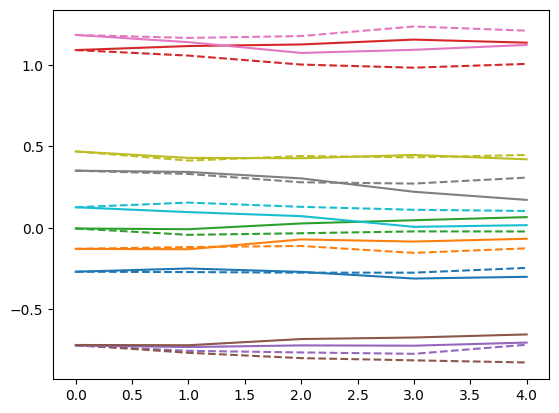

In [190]:
train_data, target_data = simulate(A)
print(tf.nn.l2_loss(train_data - target_data))
plt.plot(train_data[1], linestyle='dashed')
plt.plot(target_data[1])
plt.show()

# Training

In [191]:
def init_weights(train_data, target_data):

    with tf.GradientTape() as tape:

        train_data_flat = np.reshape(train_data, [sample_size, num_input_nodes])
        target_data_flat = np.reshape(target_data, [sample_size, num_input_nodes])
        A = tf.reduce_mean(model(train_data_flat, target_data_flat), axis=0)
        A = tf.reshape(A, [N, N])

        # Compute loss value
        loss_value = tf.nn.l2_loss(A - tf.eye(N))

    # Use gradient tape to retrieve gradients of trainable variables with respect to loss
    grads = tape.gradient(loss_value, model.trainable_weights)

    # Run one step of gradient descent by updating the value of the variables to minimise the loss
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    return loss_value, A

In [192]:
# Initialise weights of neural net to output identity matrix
loss_value = 1
while loss_value > 1e-3:
    loss_value, A = init_weights(train_data, target_data)

In [193]:
#@tf.function(jit_compile=True)
def train_step(train_data, target_data):

    with tf.GradientTape() as tape:

        A = tf.reduce_mean(model(train_data, target_data), axis=0)
        A = tf.reshape(A, [N, N])
        
        # Forward pass of the model to get training paths
        train_data, target_data = simulate(A)
        train_data_flat = tf.reshape(train_data, [sample_size, num_input_nodes])
        target_data_flat = tf.reshape(target_data, [sample_size, num_input_nodes])

        # Compute l2 loss value
        loss_value = tf.nn.l2_loss(train_data_flat - target_data_flat)

    # Use gradient tape to retrieve gradients of trainable variables with respect to loss
    grads = tape.gradient(loss_value, model.trainable_weights)

    # Run one step of gradient descent by updating the value of the variables to minimise the loss
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    return loss_value, A

In [ ]:
train_step(tf.reshape(train_data, [sample_size, num_input_nodes]), tf.reshape(target_data, [sample_size, num_input_nodes]))

In [194]:
def training_algorithm(A, num_epochs):

    # Initialise metrics to get mean loss per epoch and episode
    epoch_loss_metric = tf.keras.metrics.Mean(name='epoch_loss', dtype=tf.float32)

    # Benchmark training time
    start_time = time.time()

    # Inner loop to train neural net
    for epoch in np.arange(num_epochs):
    
        # Initialize to store average mini-batch loss per epoch
        epoch_loss_metric.reset_states()

        # Generate synthetic training data and flatten
        train_data, target_data = simulate(A)
        train_data = tf.reshape(train_data, [sample_size, num_input_nodes])
        target_data = tf.reshape(target_data, [sample_size, num_input_nodes])
    
        # Training step
        loss_value, A = train_step(train_data, target_data)      
                    
        # Update the metrics per epoch
        epoch_loss_metric.update_state(loss_value)
            
        # Get the metric results
        epoch_mean_loss = epoch_loss_metric.result()

        # Summary stats per epoch
        tf.summary.scalar('epoch_loss', epoch_mean_loss, step=epoch)
        if epoch % 10 == 0:
            tf.print(f"Epoch {epoch}: Loss: {epoch_mean_loss:.5f}")

    # Print total training time
    print(f"Training took {time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))}")

    return A

In [195]:
training_algorithm(A, 100)

Epoch 0: Loss: 49.44914
Epoch 10: Loss: 49.78391
Epoch 20: Loss: 50.82729
Epoch 30: Loss: 50.39228
Epoch 40: Loss: 48.66446
Epoch 50: Loss: 50.53717
Epoch 60: Loss: 49.96931
Epoch 70: Loss: 50.23135
Epoch 80: Loss: 48.91621
Epoch 90: Loss: 49.95747
Training took 00:06:37


<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[9.99051750e-01, 9.71454952e-04, 2.32024561e-03, 1.03284291e-03,
        1.76883454e-03, 3.02840793e-03, 1.33699575e-03, 7.44973891e-04,
        1.77634344e-03, 1.27322157e-03],
       [9.93725727e-04, 9.97281373e-01, 2.09223665e-03, 1.29569718e-03,
        6.28097972e-04, 1.01404935e-02, 2.78248306e-04, 1.48929190e-03,
        2.55156332e-03, 5.49510820e-03],
       [8.42051057e-04, 4.17164713e-03, 9.98521805e-01, 1.36041257e-03,
        1.51846884e-03, 5.61391003e-04, 1.24679250e-03, 2.27192440e-03,
        1.19452260e-03, 6.79612532e-03],
       [5.08804154e-03, 1.76230489e-04, 7.49924686e-03, 9.96611595e-01,
        2.35925009e-03, 2.13906798e-03, 4.22996411e-04, 2.07642047e-03,
        1.52997824e-03, 7.69734103e-03],
       [4.36851615e-03, 2.42443429e-03, 3.51147796e-03, 1.12635631e-03,
        9.99176621e-01, 2.29121069e-03, 4.26400872e-03, 8.95890221e-03,
        1.10854267e-03, 7.10962864e-04],
       [1.40009390e-03, 4

In [201]:
# Deviation of predicted adjacency matrix against actual
tf.nn.l2_loss(A - obj.A)

<tf.Tensor: shape=(), dtype=float32, numpy=21.86715>